In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [2]:
data_path = '../data/CALC_STRAIGHT_CLEAN/'
files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

In [3]:
print('STRAIGHT SEGMENTS:\t'+ str(len(files)))

STRAIGHT SEGMENTS:	311


In [4]:
A = pd.read_csv('../data/STRAIGHT_STEP_FREQ_CLEAN.csv')
A.head()

,File,IndexStart,IndexEnd,StepsL,StepsR,Ts,SegLen,TimeLen,StepFreqL,StepFreqR,MaxDir,MinDir,MeanDir,StdDir,Type
0,N-01-1-Char00part2seg-9_sub_0.csv,58127.0,59961.0,12.0,13.0,0.008,1835.0,14.680,0.817439,0.885559,-65.195771,-134.512166,-80.112084,6.818842,N
1,A-615829-Char00part1seg-4_sub_1.csv,37215.0,37836.0,3.0,2.0,0.008,622.0,4.976,0.602894,0.401929,151.185526,17.011236,90.361148,31.200162,A
2,N-25031996-Char00part3seg-2_sub_0.csv,24585.0,26738.0,14.0,14.0,0.008,2154.0,17.232,0.812442,0.812442,115.613353,-117.315695,-74.752300,12.243346,N
3,A-766012-Char00part1seg-1_sub_5.csv,5114.0,6533.0,11.0,10.0,0.017,1420.0,24.140,0.455675,0.414250,31.103251,-71.406641,-20.846895,20.233188,A
4,N-740516-Char00part3seg-0_sub_0.csv,7316.0,8149.0,13.0,12.0,0.017,834.0,14.178,0.916914,0.846382,-35.739444,-136.718920,-108.459980,16.910178,N


In [5]:
text_file = open('../data/JointNamesCalc.txt', "r")
joint_names_calc = text_file.read().split('\n')
len(joint_names_calc)

61

In [6]:
spine_joints = ['Spine3','Spine2','Spine1','Spine','Hips']
spine_joints_ind = np.zeros([len(spine_joints),1])
cc = 0
for c in spine_joints:
    spine_joints_ind[cc] = joint_names_calc.index(c) + 1
    cc+=1
spine_joints_ind

array([[18.],
       [19.],
       [20.],
       [21.],
       [ 1.]])

In [7]:
def euclidean(df):
    N = np.size(df,axis=0)
    dist = np.zeros((N-1))
    for n in range(1,N):
        dist[n-1] = ((df.iloc[n,0]-df.iloc[n-1,0])**2+(df.iloc[n,1]-df.iloc[n-1,1])**2+(df.iloc[n,2]-df.iloc[n-1,2])**2)**(1/2)
    return dist
        

In [8]:
def XY_len(df):
    return ((df.iloc[-1,0]-df.iloc[0,0])**2+(df.iloc[-1,1]-df.iloc[0,1])**2)**(1/2)

In [9]:
def mean_xyz(df):
    avg = pd.DataFrame()
    for dim in ['x','y','z']:
        dim_cols = [s for s in df.columns.to_list() if dim in s]
        dim_df = df.filter(dim_cols,axis=1)
        avg[dim] = np.mean(dim_df,axis=1)
    return avg

In [10]:
def module(joint):
    N = np.size(joint,axis=0)
    module = np.zeros((N))
    for n in range(0,N):
        module[n] = ((joint.iloc[n,0])**2+(joint.iloc[n,1])**2+(joint.iloc[n,2])**2)**(1/2)
    return module

In [16]:
for file in tqdm(files):
    step_len_L = np.empty(0)
    step_len_R = np.empty(0)

    XY_len_L = np.empty(0)
    XY_len_R = np.empty(0)
    
    rel_len_L = np.empty(0)
    rel_len_R = np.empty(0)
    
    sd = np.empty(0)
    sd_x = np.empty(0)
    sd_y = np.empty(0)
    sd_z = np.empty(0)

    #print(file)
    
    df = pd.read_csv(data_path + file)
    position_cols = [s for s in df.columns.to_list() if "X" in s]
    xdf = df.filter(position_cols,axis=1)
    
    T_sampling = A.loc[A['File'] == file,'Ts'].values
           
    peaksL = np.where(np.diff(df.contactL_clean)>0)[0]
    peaksR = np.where(np.diff(df.contactR_clean)>0)[0]
    
    if len(peaksL) < 3 or len(peaksR) < 3:
        continue
    
    if len(peaksL) > len(peaksR):
        steps = peaksL
    else:
        steps = peaksR
        
    
    start = steps[0]
    steps = steps[1:] # Exclude first and last step (before or after turn)?
    end = steps[1]
    
    for step in steps:
        #print(step)
        end = step
        # select actual step
        x = xdf.loc[start:end,:] # position only
        X = df.loc[start:end,:]  # everything
        '''
        # TODO FEATURES TO CALCULATE:                               NEEDED
DONE    1] step length by euclidean + XY first/last                 position of foot
DONE    2] step length by lenght of curve                           position of foot
DONE    3] standard deviation of spine / center of mass             position of spine/COM
DONE    4] % of frequency in frequency bands                        acceleration  
        5] coordination of limbs L hand + R foot / R hand + L foot  position of foots + hands, processed by two steps
        '''
        # LEGS
        leftleg_cols = []
        for col in x.columns.to_list():
            if '07' in col:
                leftleg_cols.append(x.columns.to_list().index(col))
        rightleg_cols = []
        for col in x.columns.to_list():
            if '04' in col:
                rightleg_cols.append(x.columns.to_list().index(col))
        foot_L_df = x.filter(x.columns[leftleg_cols],axis=1)
        foot_R_df = x.filter(x.columns[rightleg_cols],axis=1)
        
        # HANDS
        lefthand_cols = []
        for col in x.columns.to_list():
            if '15' in col:
                lefthand_cols.append(x.columns.to_list().index(col))
        righthand_cols = []
        for col in x.columns.to_list():
            if '11' in col:
                righthand_cols.append(x.columns.to_list().index(col))
        hand_L_df = x.filter(x.columns[lefthand_cols],axis=1)
        hand_R_df = x.filter(x.columns[righthand_cols],axis=1)
        
        # SPINE
        spine_cols = []
        for c in spine_joints_ind:
            for col in x.columns.to_list():
                if c<10:
                    name = '0' + str(int(c)) + '-'
                else:
                    name = str(int(c)) + '-'
                if col.startswith(name):
                    spine_cols.append(x.columns.to_list().index(col))
        spine_df = x.filter(x.columns[spine_cols],axis=1)
        
        COM = mean_xyz(spine_df)
        COMmod = module(COM)
        
        ######### STEP LENGTH ############
        
        distL = euclidean(foot_L_df)
        distR = euclidean(foot_R_df)
        
        step_len_L = np.append(step_len_L,np.sum(distL))
        step_len_R = np.append(step_len_R,np.sum(distR))
        
        XY_distL = XY_len(foot_L_df)
        XY_distR = XY_len(foot_R_df)
        
        XY_len_L = np.append(XY_len_L,XY_distL)
        XY_len_R = np.append(XY_len_R,XY_distR)
        
        rel_len_L = np.append(rel_len_L,step_len_L/XY_distL)
        rel_len_R = np.append(rel_len_R,step_len_R/XY_distR)
        
        ######### COM STANDARD DEVIATION ############
        
        sd = np.append(sd,np.std(COMmod))
        sd_x = np.append(sd_x,np.std(COM.x))
        sd_y = np.append(sd_y,np.std(COM.y))
        sd_z = np.append(sd_z,np.std(COM.z))
        
        ######### 
        
        start = end
        
    A.loc[A['File'] == file,'StepLenL'] = np.median(step_len_L)
    A.loc[A['File'] == file,'StepLenR'] = np.median(step_len_R)
    
    A.loc[A['File'] == file,'XY_LenL'] = np.median(XY_len_L)
    A.loc[A['File'] == file,'XY_LenR'] = np.median(XY_len_R)
    
    A.loc[A['File'] == file,'RelLenL'] = np.median(rel_len_L)
    A.loc[A['File'] == file,'RelLenR'] = np.median(rel_len_R)
    
    A.loc[A['File'] == file,'sd_x'] = np.median(sd_x)
    A.loc[A['File'] == file,'sd_y'] = np.median(sd_y)
    A.loc[A['File'] == file,'sd_z'] = np.median(sd_z)
    A.loc[A['File'] == file,'sd'] = np.median(sd)  


 54%|█████▍    | 169/311 [01:28<01:13,  1.95it/s]


100%|██████████| 311/311 [02:41<00:00,  1.92it/s]

## FEATURE
### STEP LENGTH (CUMULATIVE EUCLIDEAN DISTANCE)

In [17]:
for file in A.File: A.loc[A.File==file,'Subject'] = file.split('Char00')[0]+'Char00'

In [18]:
A.head()

,File,IndexStart,IndexEnd,StepsL,StepsR,Ts,SegLen,TimeLen,StepFreqL,StepFreqR,...,StepLenR,XY_LenL,XY_LenR,RelLenL,RelLenR,sd_x,sd_y,sd_z,sd,Subject
0,N-01-1-Char00part2seg-9_sub_0.csv,58127.0,59961.0,12.0,13.0,0.008,1835.0,14.680,0.817439,0.885559,...,1.588469,1.388742,1.405984,1.213055,1.149869,0.060919,0.395654,0.032226,0.264693,N-01-1-Char00
1,A-615829-Char00part1seg-4_sub_1.csv,37215.0,37836.0,3.0,2.0,0.008,622.0,4.976,0.602894,0.401929,...,0.436176,0.366732,0.377149,2.285547,1.127555,0.030508,0.102620,0.007513,0.032433,A-615829-Char00
2,N-25031996-Char00part3seg-2_sub_0.csv,24585.0,26738.0,14.0,14.0,0.008,2154.0,17.232,0.812442,0.812442,...,1.394593,1.290241,1.274903,1.121810,1.094083,0.078881,0.366500,0.018265,0.375677,N-25031996-Char00
3,A-766012-Char00part1seg-1_sub_5.csv,5114.0,6533.0,11.0,10.0,0.017,1420.0,24.140,0.455675,0.414250,...,0.875889,0.649599,0.666908,1.216244,1.259922,0.172834,0.040810,0.007404,0.151017,A-766012-Char00
4,N-740516-Char00part3seg-0_sub_0.csv,7316.0,8149.0,13.0,12.0,0.017,834.0,14.178,0.916914,0.846382,...,1.374189,1.162532,1.180342,1.304106,1.211768,0.126109,0.316030,0.015945,0.329200,N-740516-Char00


Text(0.5, 0, 'Step length [m]')

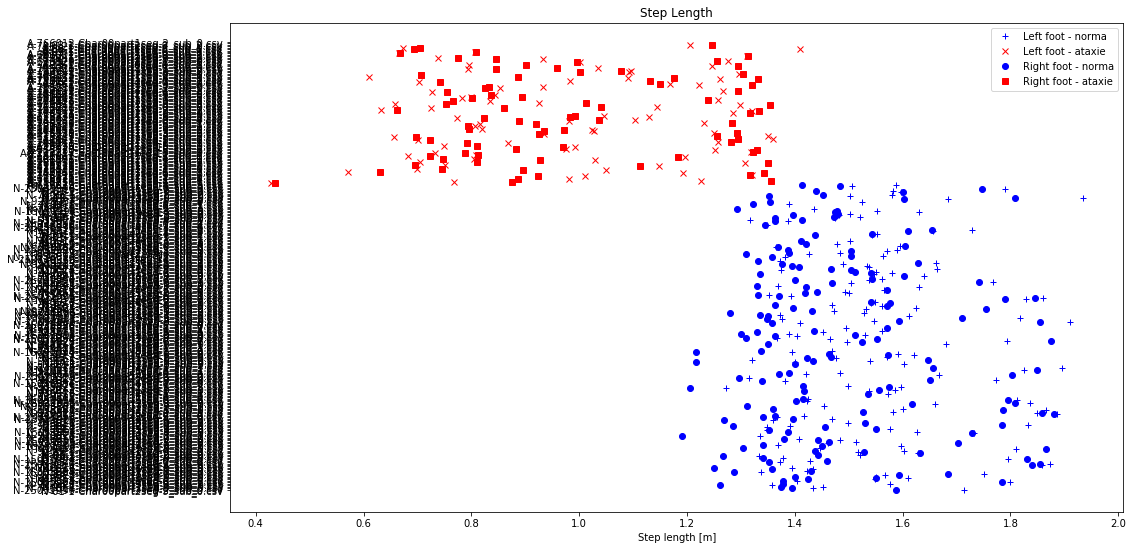

In [19]:
fig = plt.figure(figsize=(16,9))
plt.plot(A.loc[A.Type=='N','StepLenL'],A.loc[A.Type=='N','File'],'b+')
plt.plot(A.loc[A.Type=='A','StepLenL'],A.loc[A.Type=='A','File'],'rx')
plt.plot(A.loc[A.Type=='N','StepLenR'],A.loc[A.Type=='N','File'],'bo')
plt.plot(A.loc[A.Type=='A','StepLenR'],A.loc[A.Type=='A','File'],'rs')
plt.title('Step Length')
plt.legend(['Left foot - norma','Left foot - ataxie','Right foot - norma','Right foot - ataxie'])
plt.xlabel('Step length [m]')

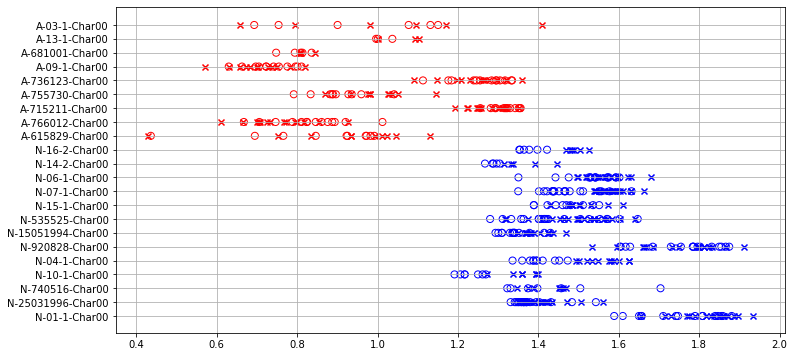

In [20]:
plt.figure(figsize=(12,6))
sub=A.loc[A['Type'] == 'N']
plt.scatter(x=sub.StepLenL,y=sub.Subject,c='b',marker='x')
plt.scatter(x=sub.StepLenR,y=sub.Subject,facecolors='none',s=50,edgecolors='b')
sub=A.loc[A['Type'] == 'A']
plt.scatter(x=sub.StepLenL,y=sub.Subject,c='r',marker='x')
plt.scatter(x=sub.StepLenR,y=sub.Subject,facecolors='none',s=50,edgecolors='r')
plt.grid()

In [21]:
A.loc[A.StepLenR < 0.5,'File']

1    A-615829-Char00part1seg-4_sub_1.csv
Name: File, dtype: object

In [22]:
A.loc[A.StepLenR > 1.6,'File']

7       N-920828-Char00part7seg-0_sub_1.csv
15      N-920828-Char00part7seg-0_sub_0.csv
23       N-01-1-Char00part2seg-12_sub_0.csv
25        N-01-1-Char00part2seg-4_sub_0.csv
28      N-920828-Char00part8seg-0_sub_0.csv
33        N-07-1-Char00part1seg-2_sub_0.csv
38      N-920828-Char00part1seg-0_sub_0.csv
43      N-740516-Char00part5seg-0_sub_1.csv
55      N-920828-Char00part9seg-0_sub_0.csv
62      N-920828-Char00part6seg-0_sub_0.csv
72        N-01-1-Char00part2seg-2_sub_0.csv
73       N-01-1-Char00part2seg-14_sub_0.csv
78      N-920828-Char00part6seg-0_sub_1.csv
85     N-920828-Char00part11seg-2_sub_0.csv
86        N-01-1-Char00part2seg-8_sub_0.csv
88      N-920828-Char00part4seg-0_sub_0.csv
107       N-01-1-Char00part2seg-5_sub_0.csv
110     N-920828-Char00part3seg-0_sub_0.csv
114     N-920828-Char00part3seg-0_sub_1.csv
115      N-01-1-Char00part2seg-13_sub_1.csv
124     N-535525-Char00part1seg-6_sub_0.csv
140     N-920828-Char00part2seg-0_sub_0.csv
158     N-920828-Char00part5seg-

### XY LENGTH OF STEPS ( euclidean distance of first and last frame in X and Y axis)

Text(0.5, 0, 'XY length [m]')

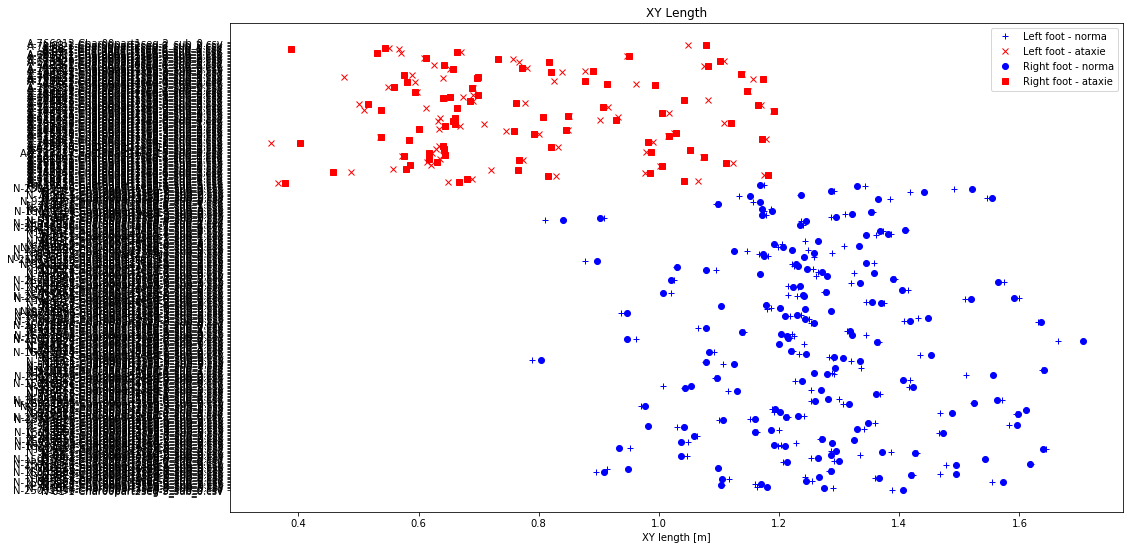

In [23]:
fig = plt.figure(figsize=(16,9))
plt.plot(A.loc[A.Type=='N','XY_LenL'],A.loc[A.Type=='N','File'],'b+')
plt.plot(A.loc[A.Type=='A','XY_LenL'],A.loc[A.Type=='A','File'],'rx')
plt.plot(A.loc[A.Type=='N','XY_LenR'],A.loc[A.Type=='N','File'],'bo')
plt.plot(A.loc[A.Type=='A','XY_LenR'],A.loc[A.Type=='A','File'],'rs')
plt.title('XY Length')
plt.legend(['Left foot - norma','Left foot - ataxie','Right foot - norma','Right foot - ataxie'])
plt.xlabel('XY length [m]')

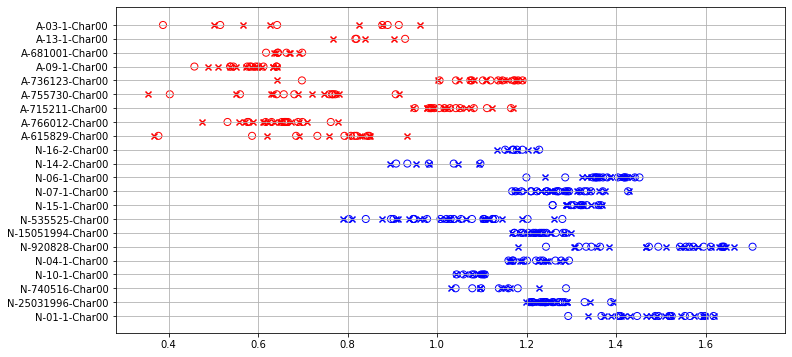

In [24]:
plt.figure(figsize=(12,6))
sub=A.loc[A['Type'] == 'N']
plt.scatter(x=sub.XY_LenL,y=sub.Subject,c='b',marker='x')
plt.scatter(x=sub.XY_LenR,y=sub.Subject,facecolors='none',s=50,edgecolors='b')
sub=A.loc[A['Type'] == 'A']
plt.scatter(x=sub.XY_LenL,y=sub.Subject,c='r',marker='x')
plt.scatter(x=sub.XY_LenR,y=sub.Subject,facecolors='none',s=50,edgecolors='r')
plt.grid()

### RELATIVE LENGTH (Euclidean sum / XY projection)

Text(0.5, 0, 'Relative Length')

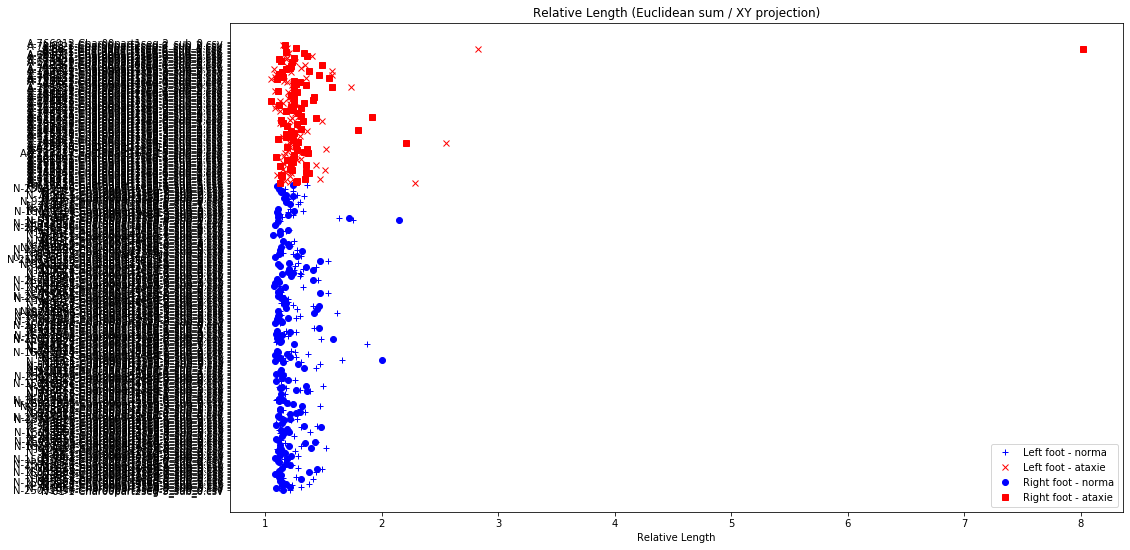

In [25]:
fig = plt.figure(figsize=(16,9))
plt.plot(A.loc[A.Type=='N','RelLenL'],A.loc[A.Type=='N','File'],'b+')
plt.plot(A.loc[A.Type=='A','RelLenL'],A.loc[A.Type=='A','File'],'rx')
plt.plot(A.loc[A.Type=='N','RelLenR'],A.loc[A.Type=='N','File'],'bo')
plt.plot(A.loc[A.Type=='A','RelLenR'],A.loc[A.Type=='A','File'],'rs')
plt.title('Relative Length (Euclidean sum / XY projection)')
plt.legend(['Left foot - norma','Left foot - ataxie','Right foot - norma','Right foot - ataxie'])
plt.xlabel('Relative Length')

(1, 2)

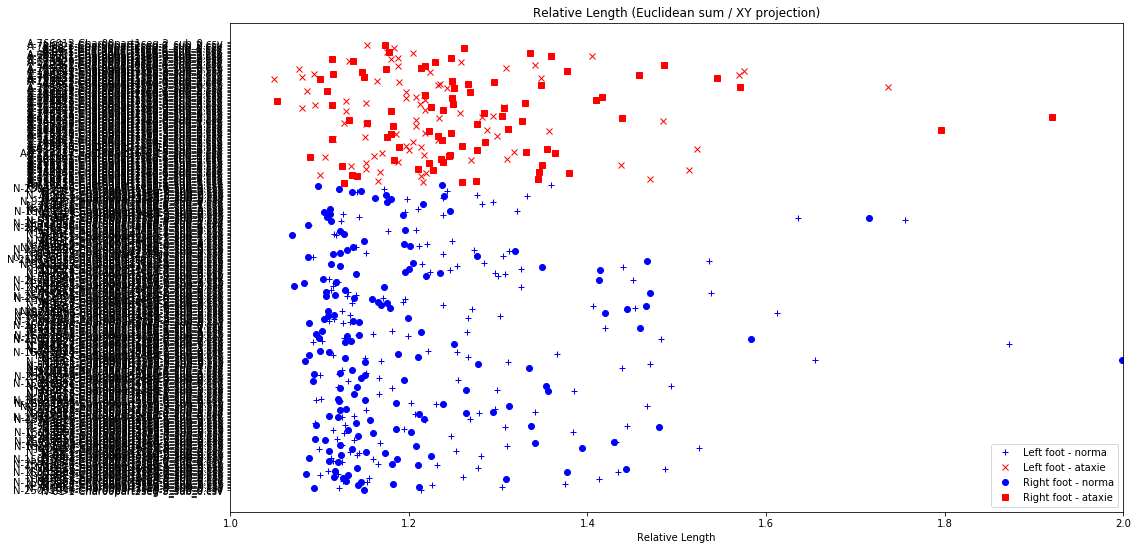

In [26]:
fig = plt.figure(figsize=(16,9))
plt.plot(A.loc[A.Type=='N','RelLenL'],A.loc[A.Type=='N','File'],'b+')
plt.plot(A.loc[A.Type=='A','RelLenL'],A.loc[A.Type=='A','File'],'rx')
plt.plot(A.loc[A.Type=='N','RelLenR'],A.loc[A.Type=='N','File'],'bo')
plt.plot(A.loc[A.Type=='A','RelLenR'],A.loc[A.Type=='A','File'],'rs')
plt.title('Relative Length (Euclidean sum / XY projection)')
plt.legend(['Left foot - norma','Left foot - ataxie','Right foot - norma','Right foot - ataxie'])
plt.xlabel('Relative Length')
plt.xlim(1,2)

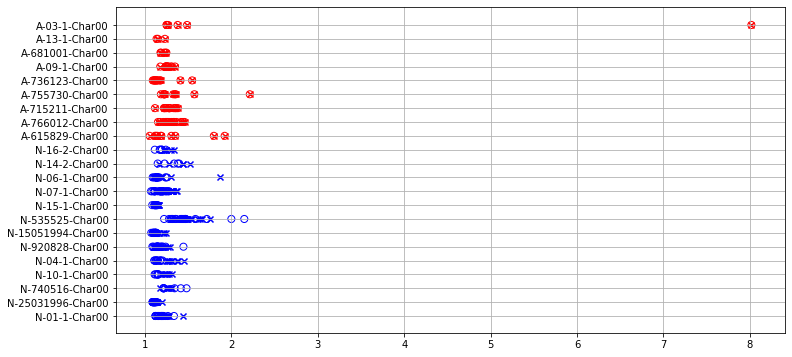

In [27]:
plt.figure(figsize=(12,6))
sub=A.loc[A['Type'] == 'N']
plt.scatter(x=sub.RelLenL,y=sub.Subject,c='b',marker='x')
plt.scatter(x=sub.RelLenR,y=sub.Subject,facecolors='none',s=50,edgecolors='b')
sub=A.loc[A['Type'] == 'A']
plt.scatter(x=sub.RelLenR,y=sub.Subject,c='r',marker='x')
plt.scatter(x=sub.RelLenR,y=sub.Subject,facecolors='none',s=50,edgecolors='r')
plt.grid()

(1, 2)

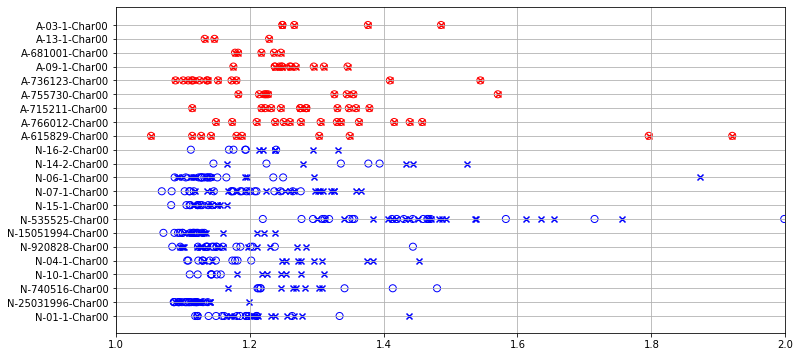

In [28]:
plt.figure(figsize=(12,6))
sub=A.loc[A['Type'] == 'N']
plt.scatter(x=sub.RelLenL,y=sub.Subject,c='b',marker='x')
plt.scatter(x=sub.RelLenR,y=sub.Subject,facecolors='none',s=50,edgecolors='b')
sub=A.loc[A['Type'] == 'A']
plt.scatter(x=sub.RelLenR,y=sub.Subject,c='r',marker='x')
plt.scatter(x=sub.RelLenR,y=sub.Subject,facecolors='none',s=50,edgecolors='r')
plt.grid()
plt.xlim(1,2)

### STANDARD DEVIATION OF COM
(COM = Center of Mass) - average joint from ['Spine3','Spine2','Spine1','Spine','Hips']

Text(0.5, 0, 'SD [m]')

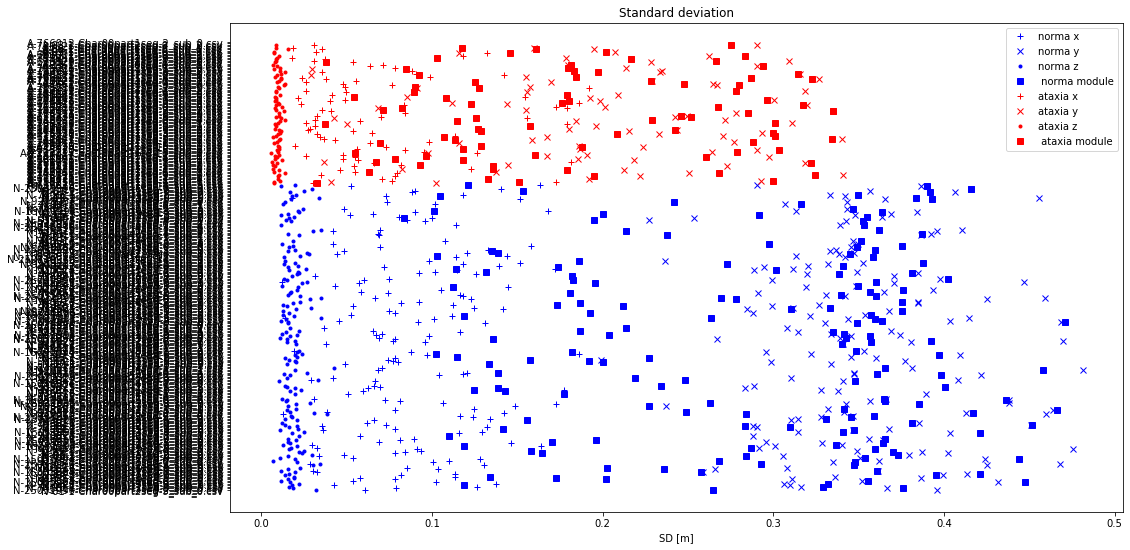

In [29]:
fig = plt.figure(figsize=(16,9))
plt.plot(A.loc[A.Type=='N','sd_x'],A.loc[A.Type=='N','File'],'b+')
plt.plot(A.loc[A.Type=='N','sd_y'],A.loc[A.Type=='N','File'],'bx')
plt.plot(A.loc[A.Type=='N','sd_z'],A.loc[A.Type=='N','File'],'b.')
plt.plot(A.loc[A.Type=='N','sd'],A.loc[A.Type=='N','File'],'bs')
plt.plot(A.loc[A.Type=='A','sd_x'],A.loc[A.Type=='A','File'],'r+')
plt.plot(A.loc[A.Type=='A','sd_y'],A.loc[A.Type=='A','File'],'rx')
plt.plot(A.loc[A.Type=='A','sd_z'],A.loc[A.Type=='A','File'],'r.')
plt.plot(A.loc[A.Type=='A','sd'],A.loc[A.Type=='A','File'],'rs')
plt.title('Standard deviation')
plt.legend(['norma x','norma y','norma z',' norma module','ataxia x','ataxia y','ataxia z',' ataxia module'])
plt.xlabel('SD [m]')

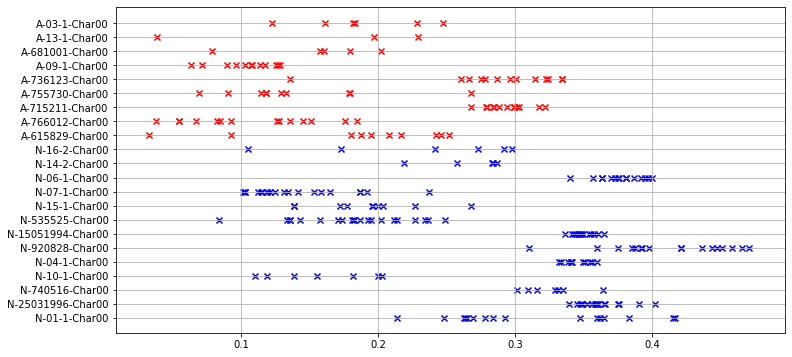

In [30]:
plt.figure(figsize=(12,6))
sub=A.loc[A['Type'] == 'N']
plt.scatter(x=sub.sd,y=sub.Subject,c='b',marker='x')
sub=A.loc[A['Type'] == 'A']
plt.scatter(x=sub.sd,y=sub.Subject,c='r',marker='x')
plt.grid()

### DIRECTION

Text(0.5, 1.0, 'STD')

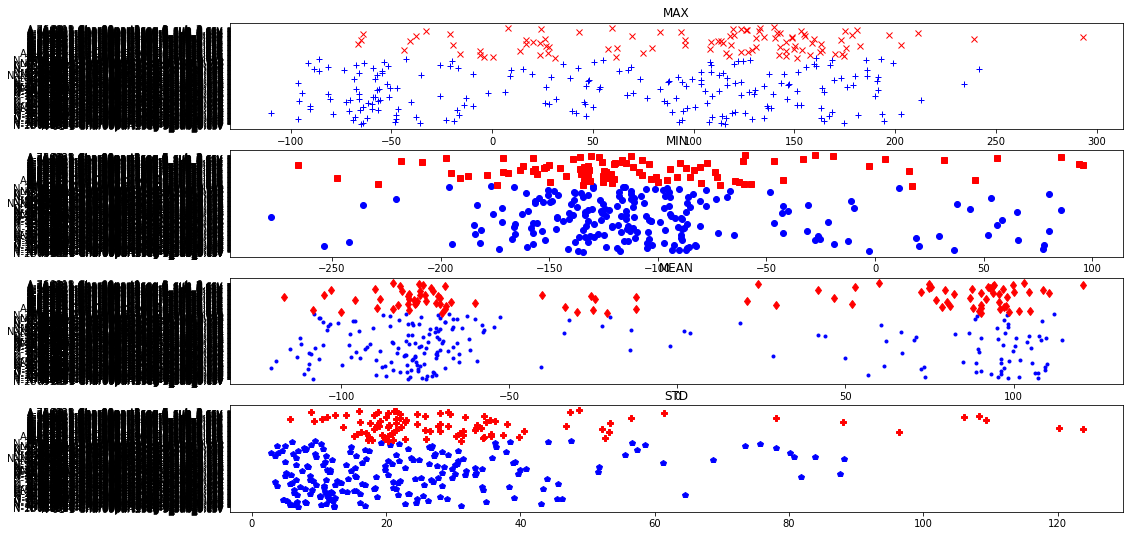

In [31]:
fig,ax = plt.subplots(4,1,figsize=(16,9))
ax[0].plot(A.loc[A.Type=='N','MaxDir'],A.loc[A.Type=='N','File'],'b+')
ax[0].plot(A.loc[A.Type=='A','MaxDir'],A.loc[A.Type=='A','File'],'rx')
ax[0].set_title('MAX')
ax[1].plot(A.loc[A.Type=='N','MinDir'],A.loc[A.Type=='N','File'],'bo')
ax[1].plot(A.loc[A.Type=='A','MinDir'],A.loc[A.Type=='A','File'],'rs')
ax[1].set_title('MIN')
ax[2].plot(A.loc[A.Type=='N','MeanDir'],A.loc[A.Type=='N','File'],'b.')
ax[2].plot(A.loc[A.Type=='A','MeanDir'],A.loc[A.Type=='A','File'],'rd')
ax[2].set_title('MEAN')
ax[3].plot(A.loc[A.Type=='N','StdDir'],A.loc[A.Type=='N','File'],'bp')
ax[3].plot(A.loc[A.Type=='A','StdDir'],A.loc[A.Type=='A','File'],'rP')
ax[3].set_title('STD')

In [32]:
A.loc[A.StdDir > 60,'File']

55      N-920828-Char00part9seg-0_sub_0.csv
95      A-615829-Char00part1seg-5_sub_0.csv
130       N-10-1-Char00part7seg-0_sub_0.csv
145       N-15-1-Char00part4seg-0_sub_0.csv
151     A-766012-Char00part1seg-0_sub_0.csv
156     A-766012-Char00part1seg-0_sub_1.csv
199     N-535525-Char00part1seg-5_sub_0.csv
211       N-04-1-Char00part6seg-0_sub_0.csv
216     A-766012-Char00part1seg-3_sub_0.csv
220       N-04-1-Char00part4seg-0_sub_0.csv
225      N-01-1-Char00part2seg-11_sub_2.csv
226     N-740516-Char00part6seg-4_sub_0.csv
233     A-766012-Char00part1seg-4_sub_2.csv
242       N-04-1-Char00part3seg-0_sub_0.csv
249     A-736123-Char00part1seg-0_sub_1.csv
253     A-766012-Char00part1seg-4_sub_1.csv
263     A-766012-Char00part1seg-2_sub_2.csv
276       N-04-1-Char00part2seg-0_sub_0.csv
285     N-740516-Char00part6seg-2_sub_0.csv
286     A-766012-Char00part1seg-2_sub_1.csv
294    N-920828-Char00part10seg-0_sub_0.csv
Name: File, dtype: object

In [33]:
A.to_csv('../data/FEATURES.csv',index=False)